In [102]:
%reset -f
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import random
import time
import math

almNum = 3
ocorr = 10
t_sample = 60
base_hour = dt.datetime(2018, 1,9,9,0,0)
occor_num = 0

#Settings alarms
a = np.zeros(1, dtype=int)
duration = 120 #120sec
hour_init = base_hour

b = np.zeros(1, dtype=int)
pAb = 1
delay_b = 120#seconds
duration_b =120

c = np.zeros(1, dtype=int)
pAc = 1
delay_c = 120#seconds
duration_c = 120

#Alarm Series Generation, A (cause), B(Effect). C(Effect)
while(occor_num < ocorr): 
    #A generation - begin
    srtd_hour = random.normalvariate(3, 1)
    srtd_hour_begin = hour_init + dt.timedelta(hours=srtd_hour)
    srtd_hour_end = srtd_hour_begin + dt.timedelta(seconds = duration)

    idx_init_a_occor = int(math.ceil((srtd_hour_begin - base_hour).total_seconds()/t_sample))
    idx_end_a_occor = int(math.ceil((srtd_hour_end - base_hour).total_seconds()/t_sample))
        
    if(idx_end_a_occor > a.size):
            a.resize(idx_end_a_occor)

    for i in np.arange(idx_init_a_occor, idx_end_a_occor + 1):
        a[i-1] = 1
    #A generation - end
         
    
    #B generation begin
    srtd_prob_b = random.uniform(0,1)  
    if srtd_prob_b <= pAb:
        srtd_hour_begin_b = srtd_hour_begin + dt.timedelta(seconds = delay_b)
        srtd_hour_end_b = srtd_hour_begin_b + dt.timedelta(seconds=duration_b)

        idx_init_b_occor = int(math.ceil((srtd_hour_begin_b - base_hour).total_seconds()/t_sample))
        idx_end_b_occor = int(math.ceil((srtd_hour_end_b - base_hour).total_seconds()/t_sample))

        if(idx_end_b_occor > b.size):
                b.resize(idx_end_b_occor)

        for j in np.arange(idx_init_b_occor, idx_end_b_occor +1):
            b[j-1] =  1  
    #B generation end

    #C generation begin
    srtd_prob_c = random.uniform(0,1)
    if srtd_prob_c <= pAc:
        srtd_hour_begin_c = srtd_hour_begin + dt.timedelta(seconds = delay_c)
        srtd_hour_end_c = srtd_hour_begin_c + dt.timedelta(seconds=duration_c)

        idx_init_c_occor = int(math.ceil((srtd_hour_begin_c - base_hour).total_seconds()/t_sample))
        idx_end_c_occor = int(math.ceil((srtd_hour_end_c - base_hour).total_seconds()/t_sample))
        
        if(idx_end_c_occor > c.size):
            c.resize(idx_end_c_occor)

        for j in np.arange(idx_init_c_occor, idx_end_c_occor +1):
            c[j-1] = 1    
    #C generation end
    
    hour_init = srtd_hour_begin
    occor_num = occor_num + 1

#Making series the same length
max_len = max(a, b, c, key=len).size
a = np.concatenate([a, np.zeros(max_len - a.size)])
b = np.concatenate([b, np.zeros(max_len - b.size)])
c = np.concatenate([c, np.zeros(max_len - c.size)])
sum(c)

30.0

In [129]:
def plot_mat_corrs(figsize, annot, matrix):
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
    sns.heatmap(matrix, cmap=cmap, center=0, annot=annot)
    plt.show()

In [380]:
#guess window_lag = ceil(delay_b_c/t_sample)

def interrelation(window_lag, matrix):
    #window_lag =  5#shoud be minor than size of the series


    count_occor = 0;
    corr_mat = np.zeros([matrix.shape[1],matrix.shape[1]], dtype=float)
    alrms = {}
    for i in np.arange(0, matrix.shape[1]):
        alrms[i] = matrix[:,i]
    #print(alrms)
    for idx_caus, value in alrms.items():
        reduced_alarms = alrms.copy()
        del reduced_alarms[idx_caus]
        for idx_occor_caus, occor in enumerate(value):
            if occor == 1:
                if(idx_occor_caus+window_lag < len(value)):
                    count_occor = count_occor + 1
                    for idx_fct, alm_redu in reduced_alarms.items():
                        counted = False
                        for idx_occor_fct in np.arange(idx_occor_caus+1, idx_occor_caus+1+window_lag):
                            if alm_redu[idx_occor_fct] == 1 and  not counted:
                                counted = True
                                corr_mat[idx_caus][idx_fct] = corr_mat[idx_caus][idx_fct]+1
        if count_occor > 0: 
            corr_mat[idx_caus] = corr_mat[idx_caus]/count_occor
            count_occor = 0
    return corr_mat

In [352]:
#Example with disturb number 4 of Tennessee Eastman

dist4 = pd.read_csv('dist_4.csv')
low = dist4[dist4.columns[1:47]][1000:]
high = dist4[dist4.columns[74:120]][1000:]
df_22 = pd.concat([low,high], axis=1)


df_diff = df_22.diff(1)
df_diff.iloc[0] = df_22.iloc[0]
matrix =(df_diff.as_matrix()).astype(int)

corr = interrelation(5, matrix)


#low i 45 high 91  - var 46
#low i 8 high 54  - var 9

print(corr[91,54]) #hh
print(corr[45,8])  #ll
print(corr[45,54])  #lh
print(corr[91,8]) #hl

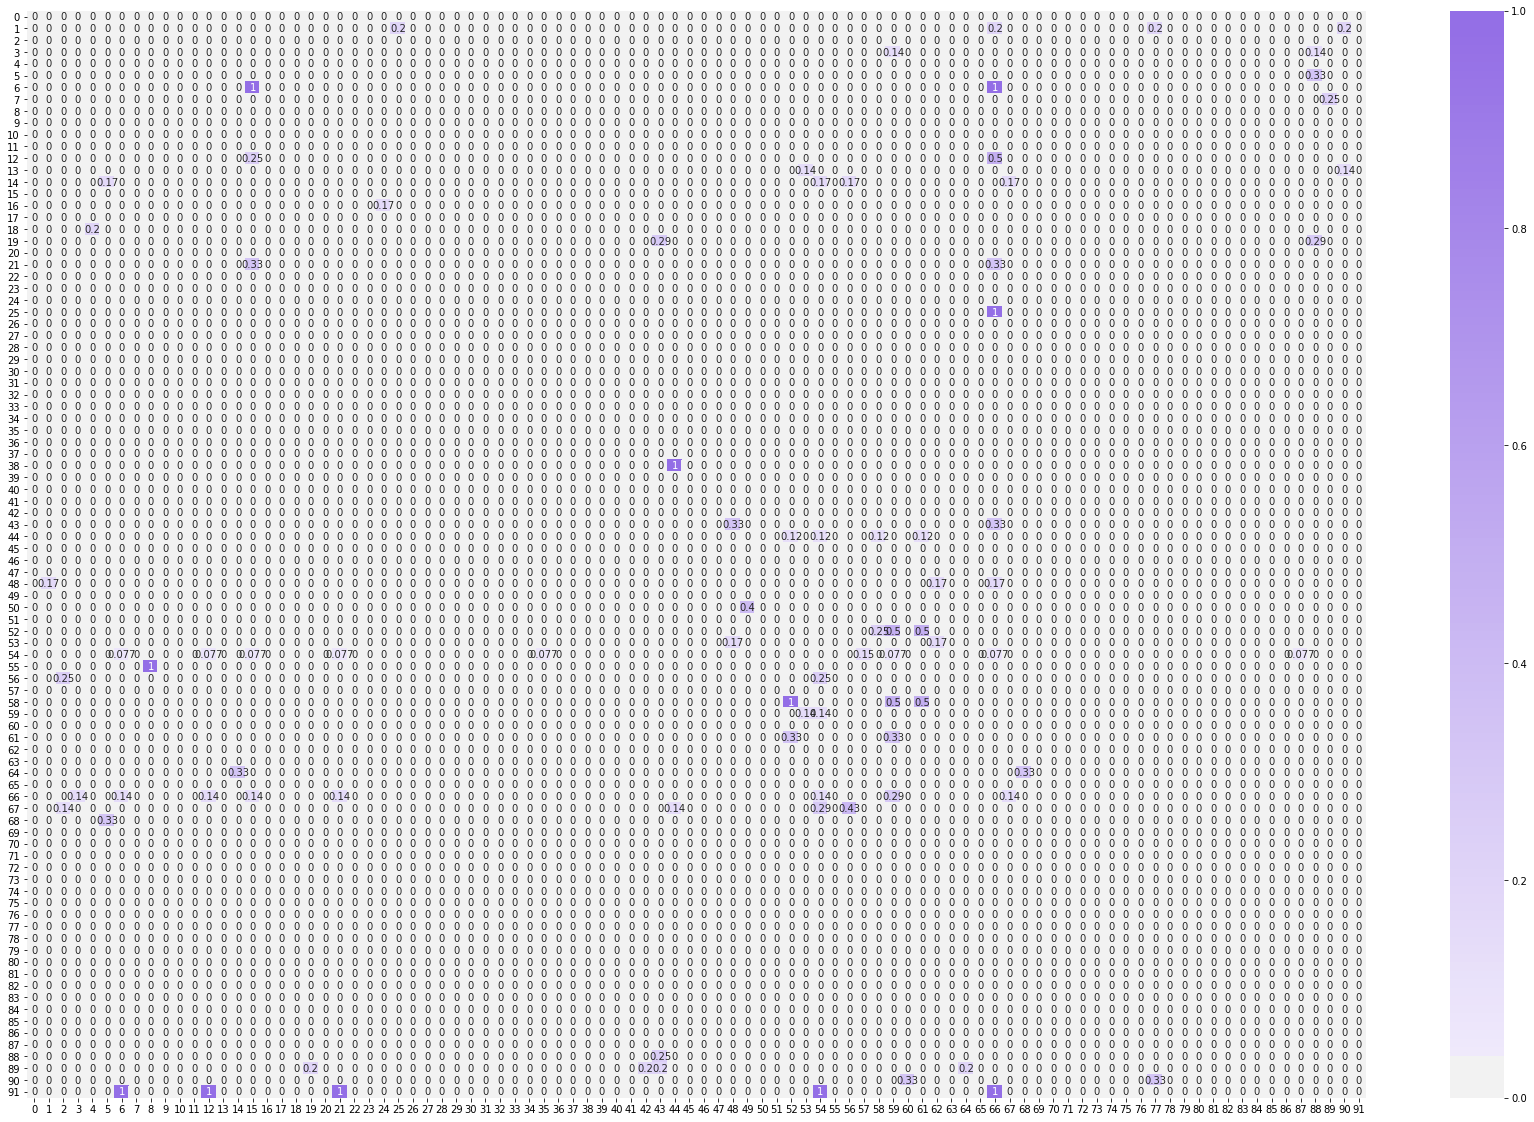

In [383]:
plot_mat_corrs(figsize=(30,20), annot=True, matrix=corr)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5b8e2e128>,
      dtype=object)

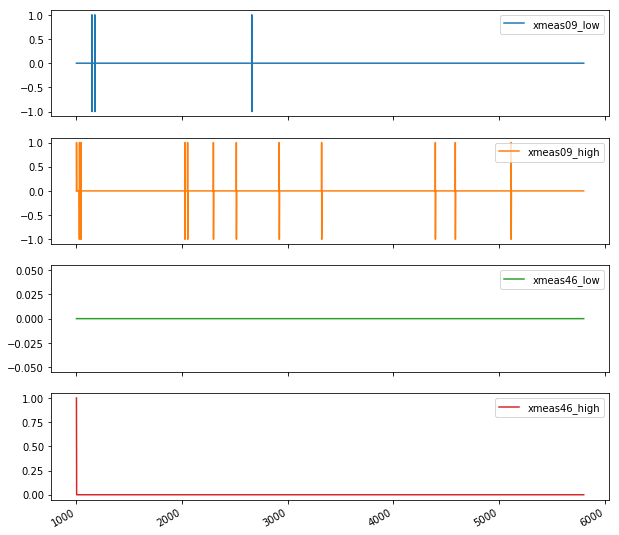

In [384]:
df_diff[['xmeas09_low','xmeas09_high', 'xmeas46_low', 'xmeas46_high' ]].plot(figsize=(10,10),subplots=True)